# <span style="color:blue">**VALUE CUSTOMER IDENTIFICATION**</span> 

# PLANEJAMENTO DA SOLUÇÃO

## **Input - Entrada**

**O problema de negócio**

1. Selecionar os mais valiosos clientes para formar o programa de fidelidade "INSIDERS".
2. Conjunto de dados com as vendas de produtos durante 1 ano (Nov 2015 a Dec 2017).
   
## **Output - Saída**
1. A indicação de pessoas para fazer parte do programa de fidelidade "INSIDERS".
2. Relatório com as respostas para as seguintes perguntas:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?
    
## **Tasks - Processo**
1. **Quem são as pessoas elegíveis para participar do programa de Insiders ?**
    - O que é ser elegível ? O que é um cliente "valioso" para a empresa ?
        - Faturamento:
            - Alto Ticket Médio
            - Alto LTV
            - Baixa Recência ou Alta Frequência ( tempo entre as compras )
            - Alto Basket Size ( quantidade média de produtos comprados )
            - Baixa probabilidade de Churn
            - Previsão alta de LTV
            - Alta propensão de compra

        - Custo:
            - Baixo número de devoluções

        - Experiência:  
            - Média alta de avaliações
            
            
2. **Quantos clientes farão parte do grupo?**
    - Número de clientes
    - % em relação ao total de clients
    
    
3. **Quais as principais características desses clientes ?**
    - Escrever os principais atributos dos clientes
        - Idade
        - País
        - Salário
        
    - Escrever os principais comportamentos de compra dos clients ( métricas de negócio )
        - Vide acima
    
    
4. **Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?**
    - Calcular o faturamento total da empresa durante o ano.
    - Calcular o faturamento (%) apenas do cluster Insiders.
    
    
5. **Qual a expectativa de faturamento desse grupo para os próximos meses ?**
    - Cálculo do LTV do grupo Insiders
    - Séries Temporais ( ARMA, ARIMA, HoltWinter, etc )
    

6. **Quais as condições para uma pessoa ser elegível ao Insiders ?**
    - Qual o período de avaliação ?
    - O "desempenho" do cliente está próximo da média do cluster Insiders. 
    
    
7. **Quais as condições para uma pessoa ser removida do Insiders ?**
    - O "desempenho" do cliente não está mais próximo da média do cluster Insiders. 
    
    
8. **Qual a garantia que o programa Insiders é melhor que o restante da base ?**
    - Teste de Hipóteses
    - Teste A/B
    
    
9. **Quais ações o time de marketing pode realizar para aumentar o faturamento?**
    - Descontos
    - Preferências de escolha
    - Produtos exclusivos

# 0 - IMPORTS

In [1]:
import re
import numpy        as np
import pandas       as pd
import seaborn      as sns
import umap.umap_   as umap

from IPython.display              import Image

from matplotlib.gridspec          import GridSpec
from matplotlib                   import pyplot       as plt

from plotly                  import express              as px

from sklearn                 import cluster              as c
from sklearn                 import metrics              as m
from sklearn                 import preprocessing        as pp
from sklearn                 import decomposition        as dd
from sklearn                 import ensemble             as en
from sklearn                 import mixture              as mx
from sklearn.manifold        import TSNE                 as mn

from scipy.cluster           import hierarchy            as hc

from yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer
#from pandas_profiling        import ProfileReport

## 0.1 - Helper functions

## 0.2 - Load dataset

In [2]:
# load data
df_raw = pd.read_csv('dataset/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1 - DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

## 1.1 - Rename columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 - Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 - Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 - Replace NA

In [8]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [9]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])
df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)

In [10]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 - Change Dtypes

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

In [12]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

## 1.7 Descriptive statistics

In [13]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numerical Attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat
stats = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
stats .columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
stats

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097


### 1.7.2 - Categorical Attributes

#### invoice_no

In [15]:
# invoice_no: Há letras e números nas strings, não se transforma em int
n_diff = len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())
perc = n_diff/cat_attributes['invoice_no'].drop_duplicates().shape[0]
print('Qtde de valores com letras: {}  |  Representatividade: {}'.format(n_diff, str(np.round(perc*100,2))+'%'))

Qtde de valores com letras: 3839  |  Representatividade: 14.82%


#### stock_code

In [16]:
# stock code
n_diff = len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())
perc = n_diff/cat_attributes['stock_code'].drop_duplicates().shape[0]
print('Qtde de valores com letras: {}  |  Representatividade: {}'.format(n_diff, str(np.round(perc*100,2))+'%'))

Qtde de valores com letras: 1124  |  Representatividade: 27.62%


In [17]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

# 2 - FILTRAGEM DE VARIÁVEIS

In [18]:
df2 = df1.copy()

In [19]:
# Numerical Attributes
# unit_price >0.04
df2 = df2.loc[df2['unit_price']>=0.04, :]

# stock_code != [POST, D, M, DOT, CRUK, C2]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop('description', axis=1)

# map - 
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users
df2 = df2[~df2['customer_id'].isin([16446])]

# quantity - negative numbers means product returns
df2_returns = df2.loc[df2['quantity']<0,:]
df2_purchase = df2.loc[df2['quantity']>=0,:]

# 3 - FEATURE ENGINEERING

In [20]:
df3 = df2.copy()

In [21]:
# data reference
df_ref = df3[['customer_id']].copy()
df_ref = df_ref.drop_duplicates(ignore_index=True)

## 3.1 - Gross Revenue | Monetary

In [22]:
# gross_revenue (Faturamento = quantity * unit_price)
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity']*df2_purchase.loc[:, 'unit_price']

# monetary
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

C:\Users\faust\AppData\Local\Temp\ipykernel_36096\203412114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:, 'quantity']*df2_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

## 3.2 - Recency - Day from last purchase

In [23]:
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_ref = pd.merge(df_ref, df_recency[['customer_id', 'recency_days']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

## 3.3 - Quantity of purchased

In [24]:
df_freq = df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'qtde_invoices'})
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

## 3.3 - Quantity of items purchased

In [25]:
df_freq = df2_purchase.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_items'})
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
dtype: int64

## 3.3 - Quantity of products purchased

In [26]:
# frequency
df_freq = df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'qtde_products'})
df_ref = pd.merge(df_ref, df_freq, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
dtype: int64

## 3.4 - Average Ticket Value

In [27]:
# Avg Ticket
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_items       91
qtde_products    91
avg_ticket       91
dtype: int64

## 3.5 - Average recency days

In [28]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=(False, False))
df_aux['next_customer_id'] = df_aux['customer_id'].shift(-1) # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift(-1) # next invoice date
df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)
df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average_recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
dtype: int64

## 3.6 - Frequency purchase

In [29]:
df_aux = (df2_purchase[['invoice_no', 'customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id')
                                                            .agg(max_ = ('invoice_date', 'max'),
                                                                 min_ = ('invoice_date', 'min'),
                                                                 days_ = ('invoice_date', lambda x: (x.max() - x.min()).days + 1),
                                                                 buy_ = ('invoice_no', 'count')).reset_index())
        
# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_']!=0 else 0, axis=1)
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

## 3.7 - Number of returns

In [30]:
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = -1*df_returns['qtde_returns']
df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

## 3.8 - Basket Size - Quantidade de itens por cesta (quantity)

In [31]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                                             n_products=('quantity', 'sum'))
                                                                        .reset_index())

df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

## 3.9 - Unique Basket Size - Quantidade de produtos distintos por compra

In [32]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                        .agg(n_purchase=('invoice_no', 'nunique'),
                                                                             n_products=('stock_code', 'nunique'))
                                                                        .reset_index())

df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

# 4 - ANÁLISE EXPLORATÓRIA DE DADOS ANTES DA MODELAGEM

In [33]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 - Univariete Analysis

## 4.2 - Bivariate Analysis

<Figure size 2500x1200 with 0 Axes>

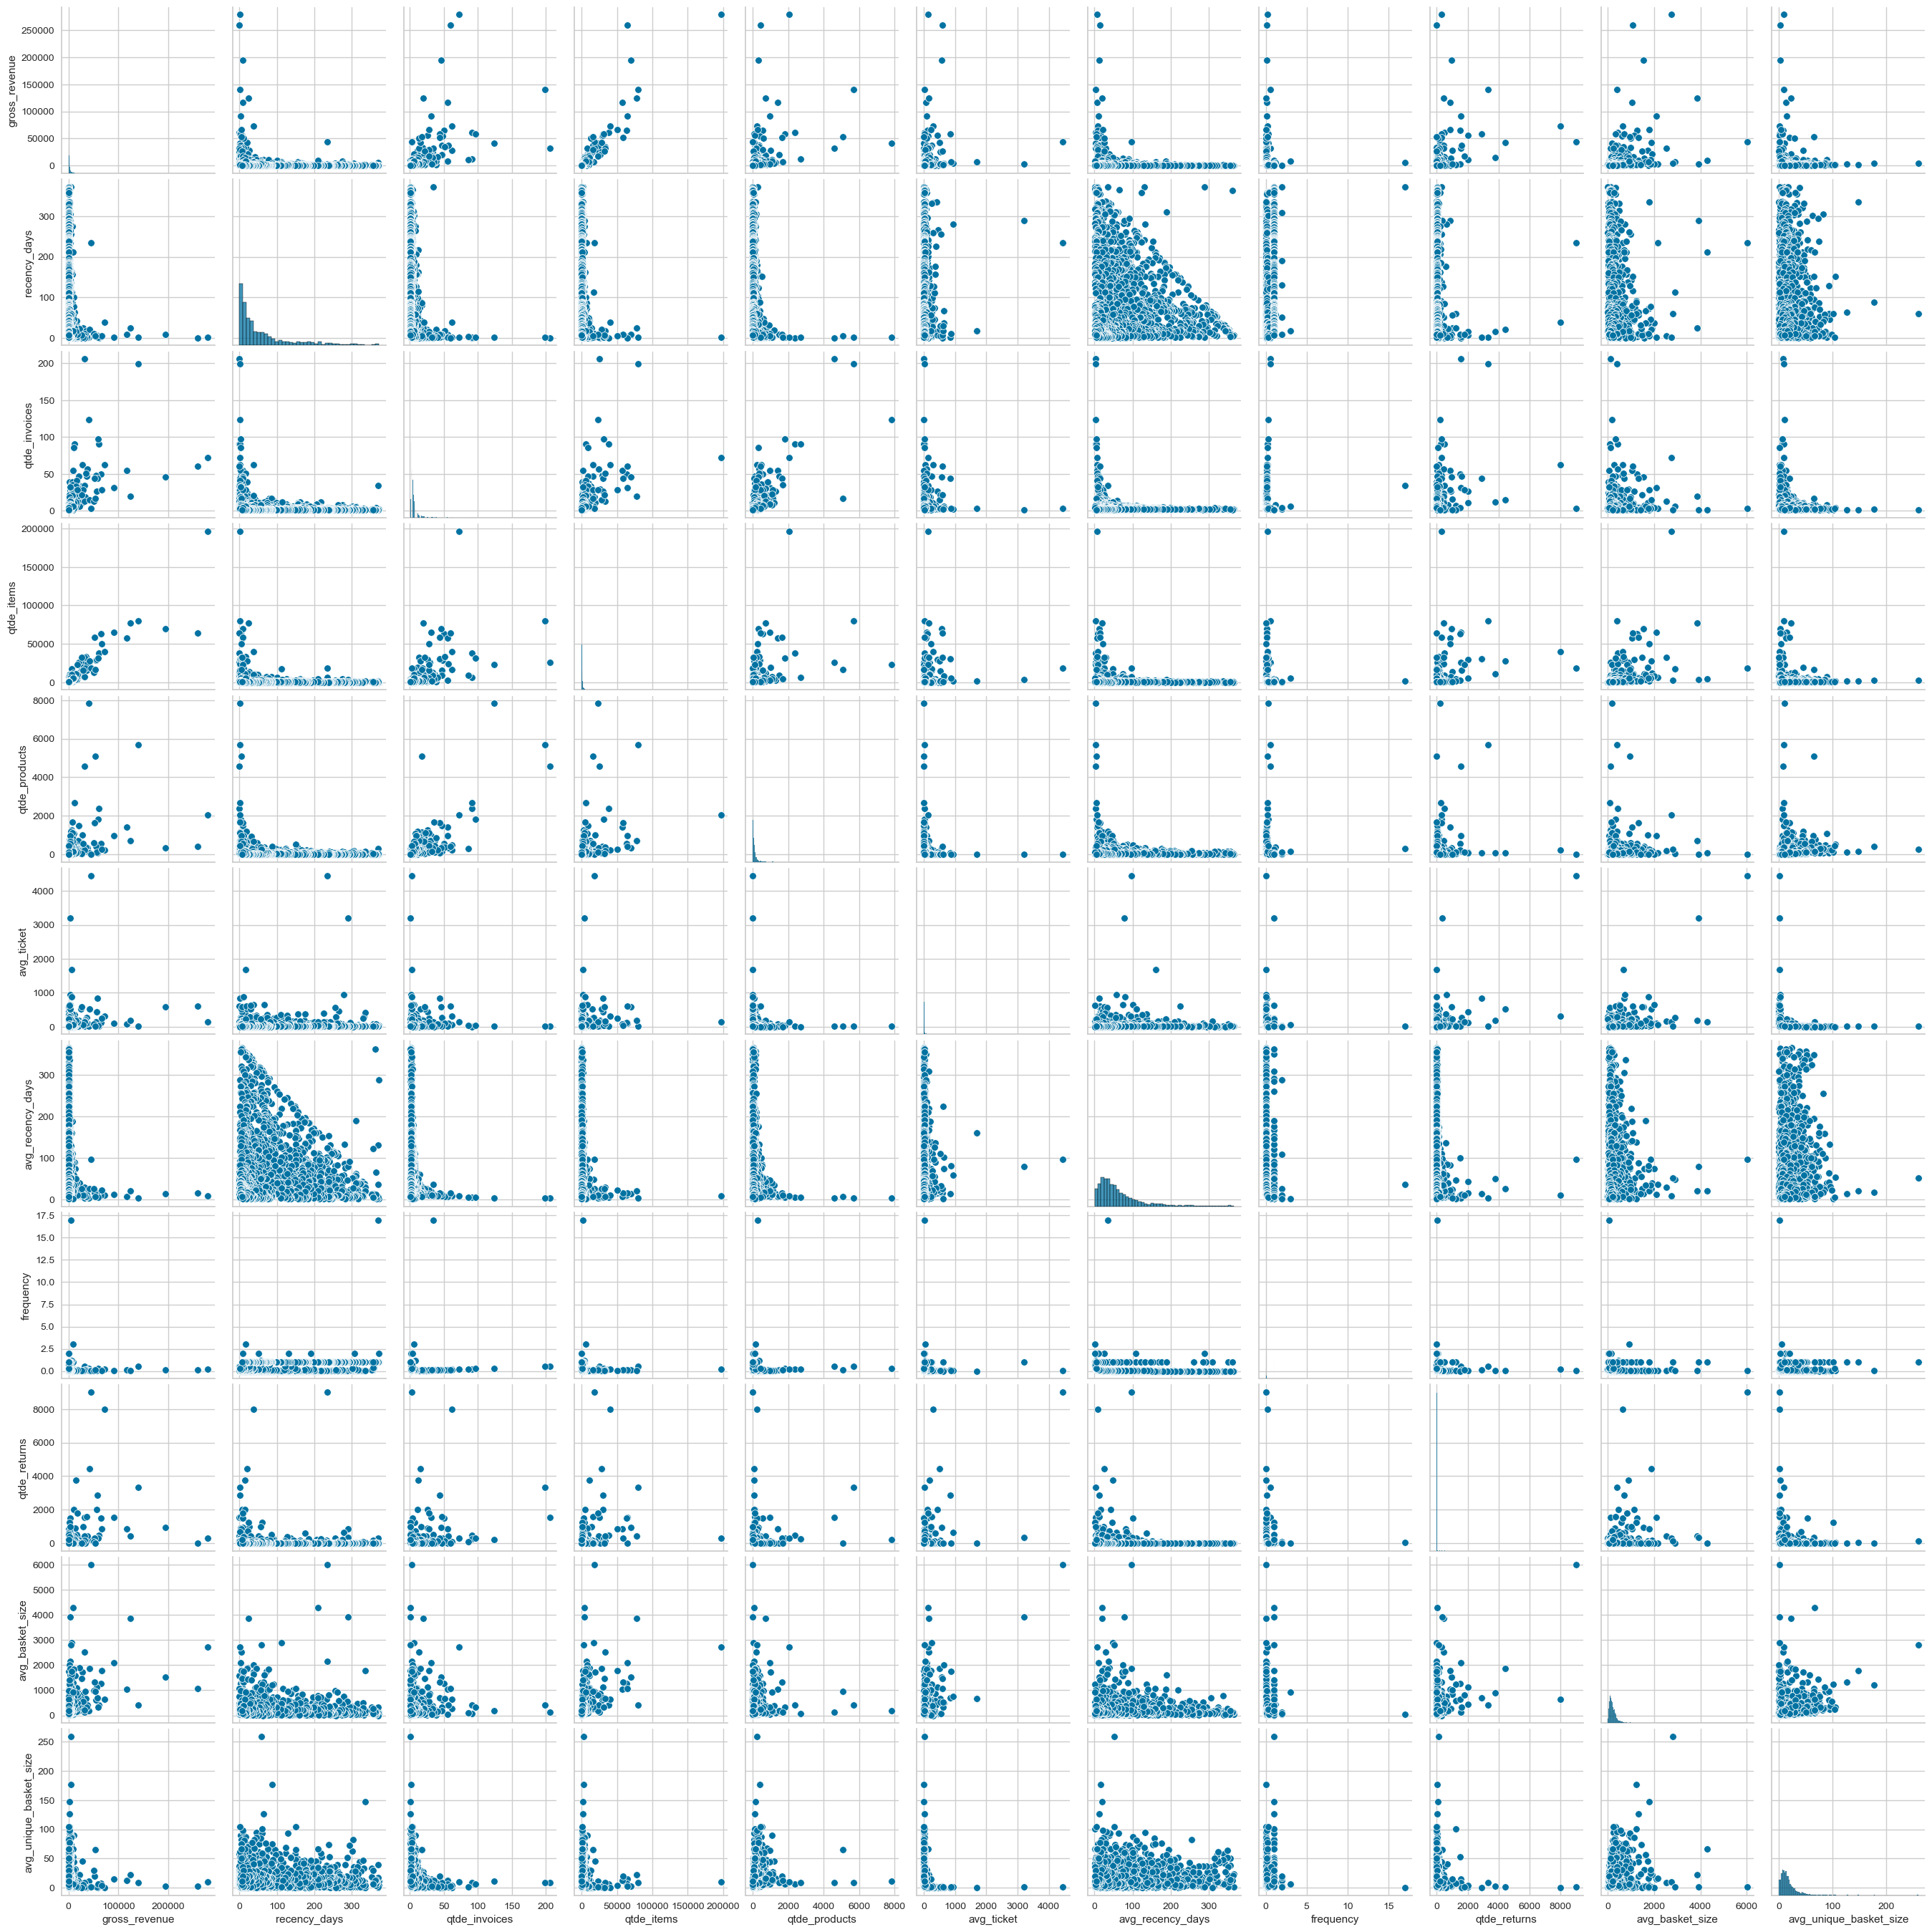

In [34]:
df42 = df4.drop('customer_id', axis=1)
plt.figure(figsize=[25, 12])
sns.pairplot(df42);

## 4.3 - Estudo de espaço

In [35]:
# original dataset
#df43 = df4.drop('customer_id', axis=1)

# Selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

In [36]:
mms = pp.MinMaxScaler()

df43['gross_revenue'] = mms.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mms.fit_transform(df43[['recency_days']])
#df43['avg_ticket'] = mms.fit_transform(df43[['avg_ticket']])
#df43['qtde_invoices'] = mms.fit_transform(df43[['qtde_invoices']])
#df43['qtde_items'] = mms.fit_transform(df43[['qtde_items']])
df43['qtde_products'] = mms.fit_transform(df43[['qtde_products']])
#df43['avg_recency_days'] = mms.fit_transform(df43[['avg_recency_days']])
#df43['avg_basket_size'] = mms.fit_transform(df43[['avg_basket_size']])
df43['frequency'] = mms.fit_transform(df43[['frequency']])
df43['qtde_returns'] = mms.fit_transform(df43[['qtde_returns']])

X = df43.copy()

### 4.3.1 - PCA

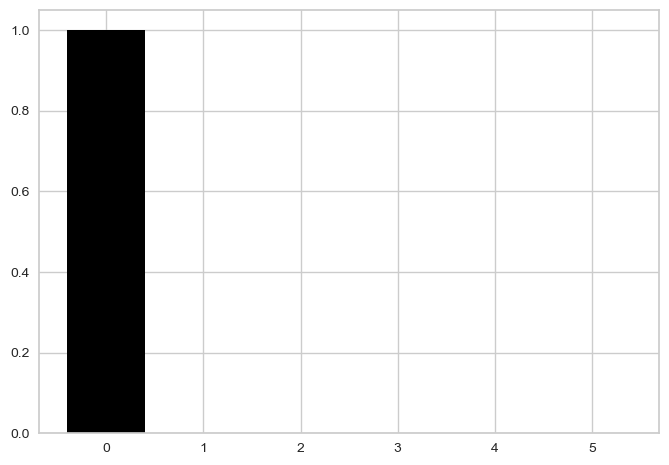

In [37]:
pca = dd.PCA(n_components=X.shape[1])
principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

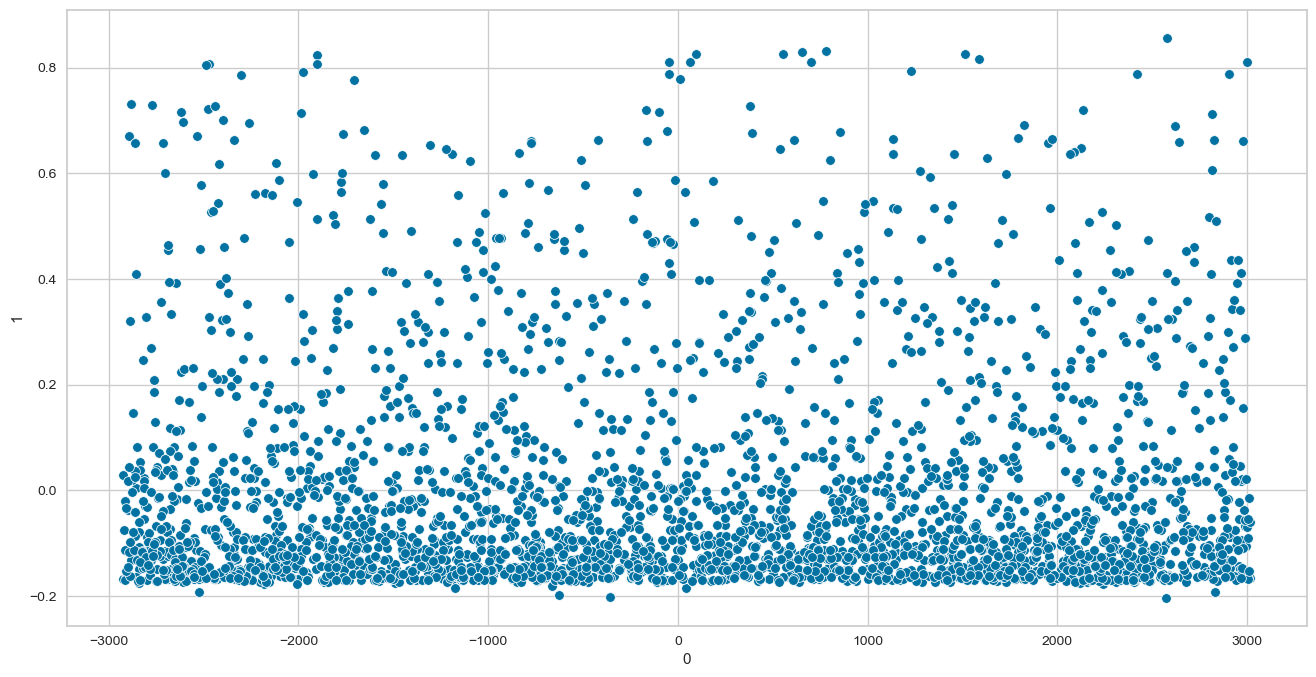

In [38]:
plt.figure(figsize=[16, 8])
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2 - UMAP

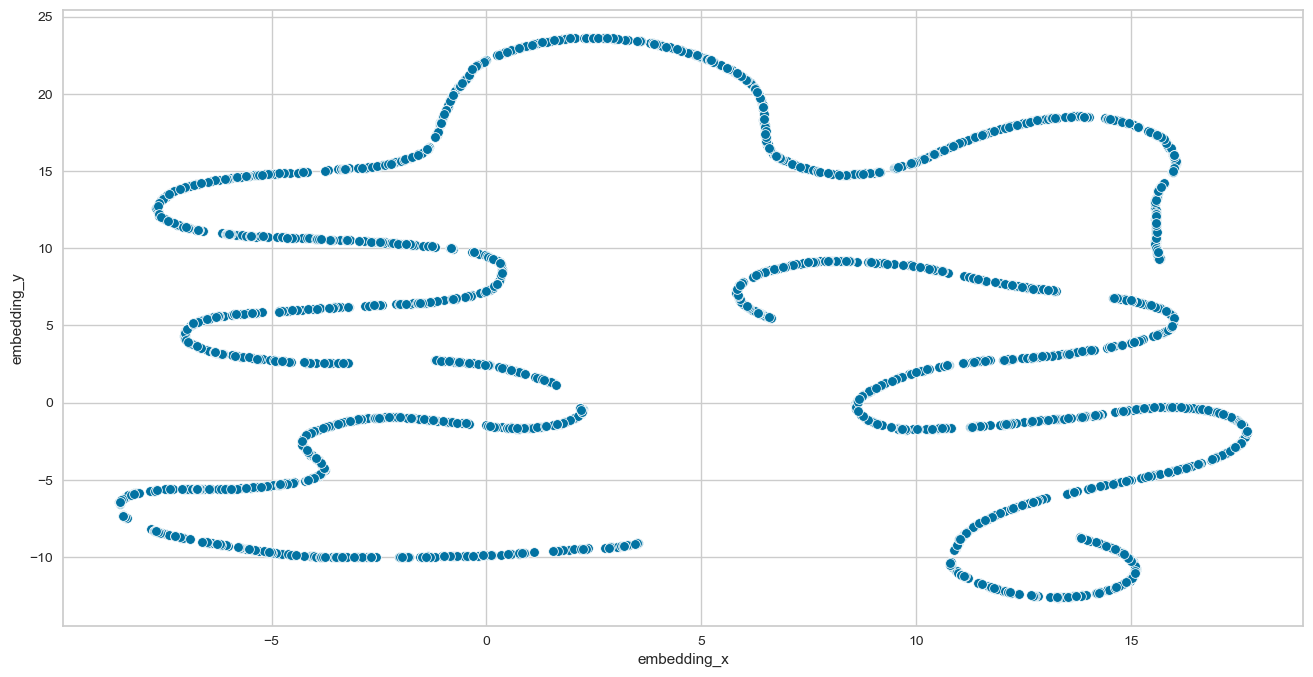

In [39]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
plt.figure(figsize=[16, 8])
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 4.3.2 - t-SNE

C:\Users\faust\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\faust\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


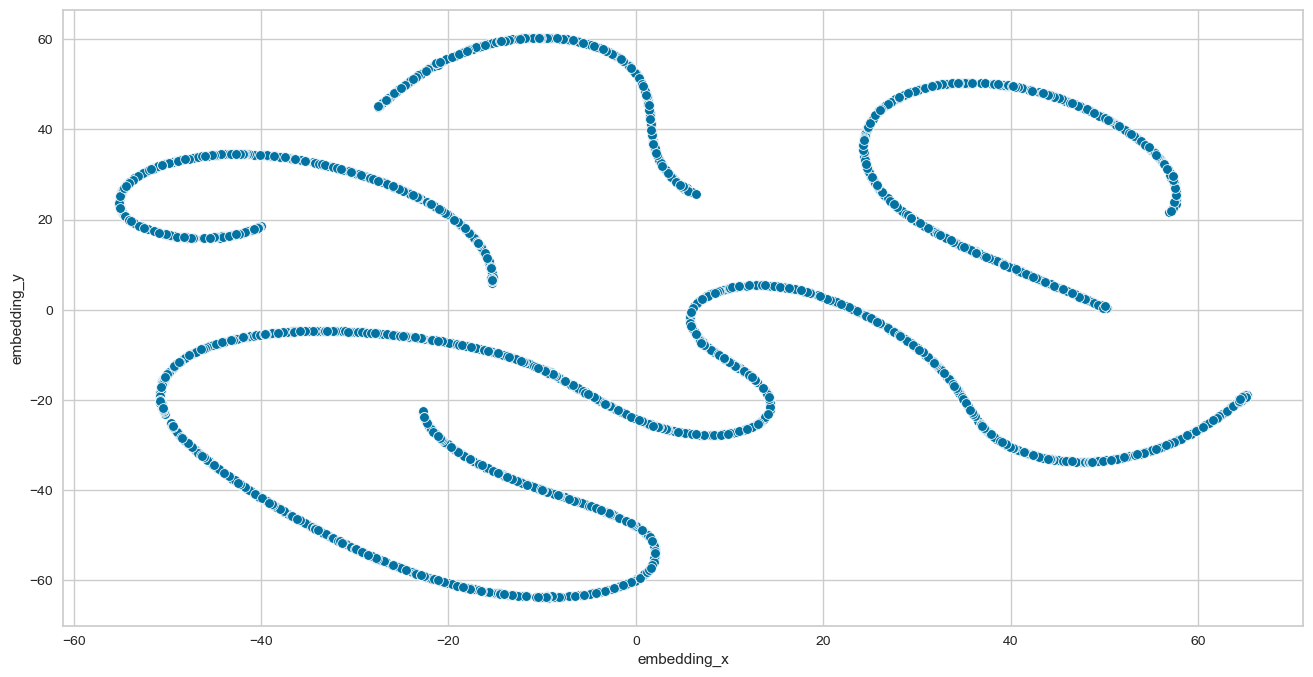

In [40]:
reducer = mn(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

#plot UMAP
plt.figure(figsize=[16, 8])
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca);

### 4.3.3 - Tree-Based Embedding

In [41]:
# training dataset
X = df43.drop(['customer_id', 'gross_revenue'], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf
df_leaf = pd.DataFrame(rf_model.apply(X))

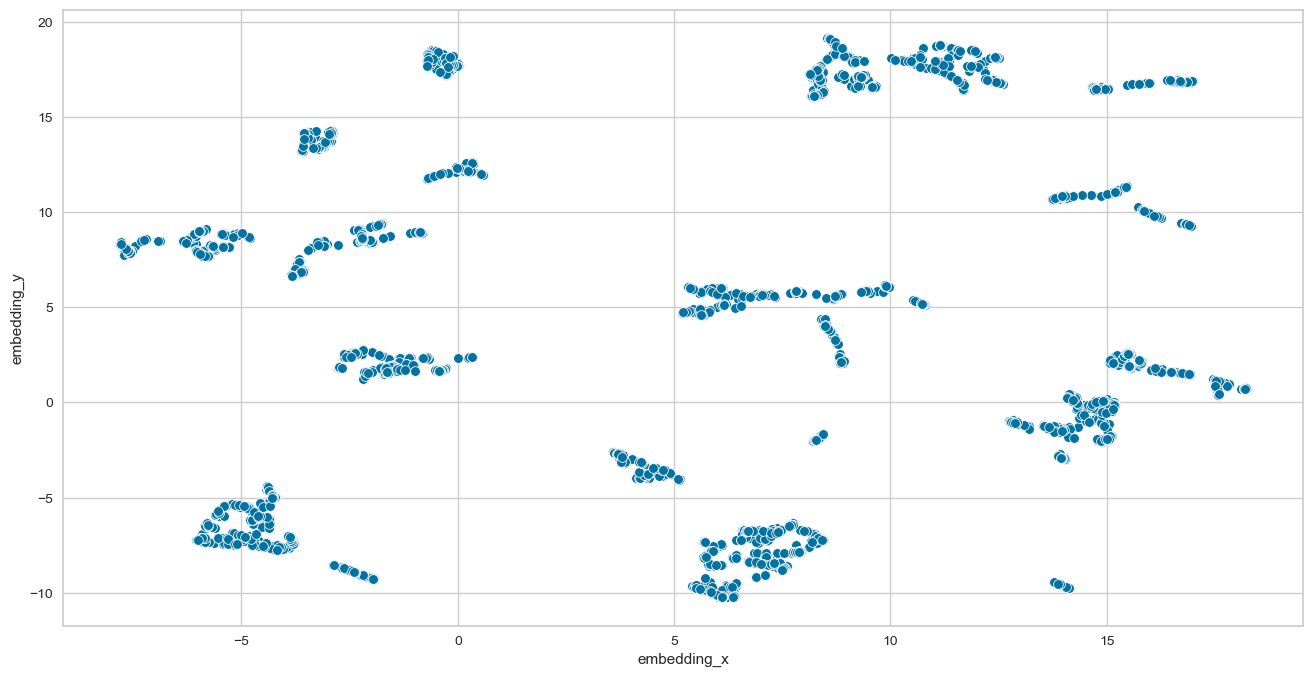

In [42]:
# umap
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP
plt.figure(figsize=[16, 8])
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# 5 - PREPARAÇÃO DOS DADOS

In [43]:
#df5 = df4.copy()
df5 = df_tree.copy()

In [44]:
# MinMax Scaler
#mms = pp.MinMaxScaler()
#
#df5['gross_revenue'] = mms.fit_transform(df5[['gross_revenue']])
#df5['recency_days'] = mms.fit_transform(df5[['recency_days']])
#df5['qtde_invoices'] = mms.fit_transform(df5[['qtde_invoices']])
#df5['qtde_items'] = mms.fit_transform(df5[['qtde_items']])
#df5['qtde_products'] = mms.fit_transform(df5[['qtde_products']])
#df5['avg_ticket'] = mms.fit_transform(df5[['avg_ticket']])
#df5['avg_recency_days'] = mms.fit_transform(df5[['avg_recency_days']])
#df5['frequency'] = mms.fit_transform(df5[['frequency']])
#df5['qtde_returns'] = mms.fit_transform(df5[['qtde_returns']])
#df5['avg_basket_size'] = mms.fit_transform(df5[['avg_basket_size']])
#df5['avg_unique_basket_size'] = mms.fit_transform(df5[['avg_unique_basket_size']])

# 6 - SELEÇÃO DE FEATURES

In [45]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [46]:
#df6 = df5[cols_selected].copy()
df6 = df5.copy()

# 7 - HYPERPARAMETER FINE-TUNING

In [47]:
#X = df6.drop('customer_id', axis=1)
X = df6.copy()

In [48]:
clusters = np.arange(2, 25).tolist()

## 7.1 - K-Means

In [49]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k, random_state=42)
    
    # model training
    kmeans_model.fit(X)
    
    # model predict
    labels = kmeans_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

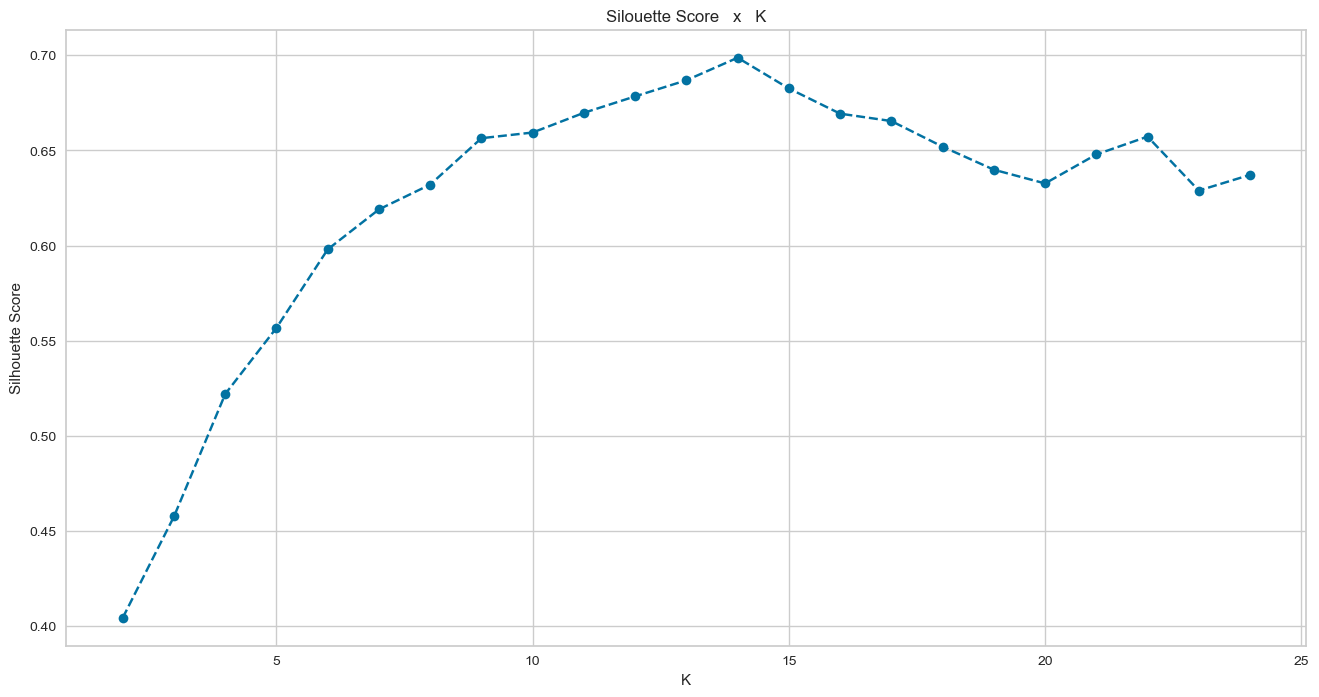

In [50]:
plt.figure(figsize=[16,8])
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K');

## 7.2 Gaussian Mixture Model (GMM)

In [51]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k, random_state=42)
    
    # model training
    gmm_model.fit(X)
    
    # model predict
    labels = gmm_model.predict(X)
    
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

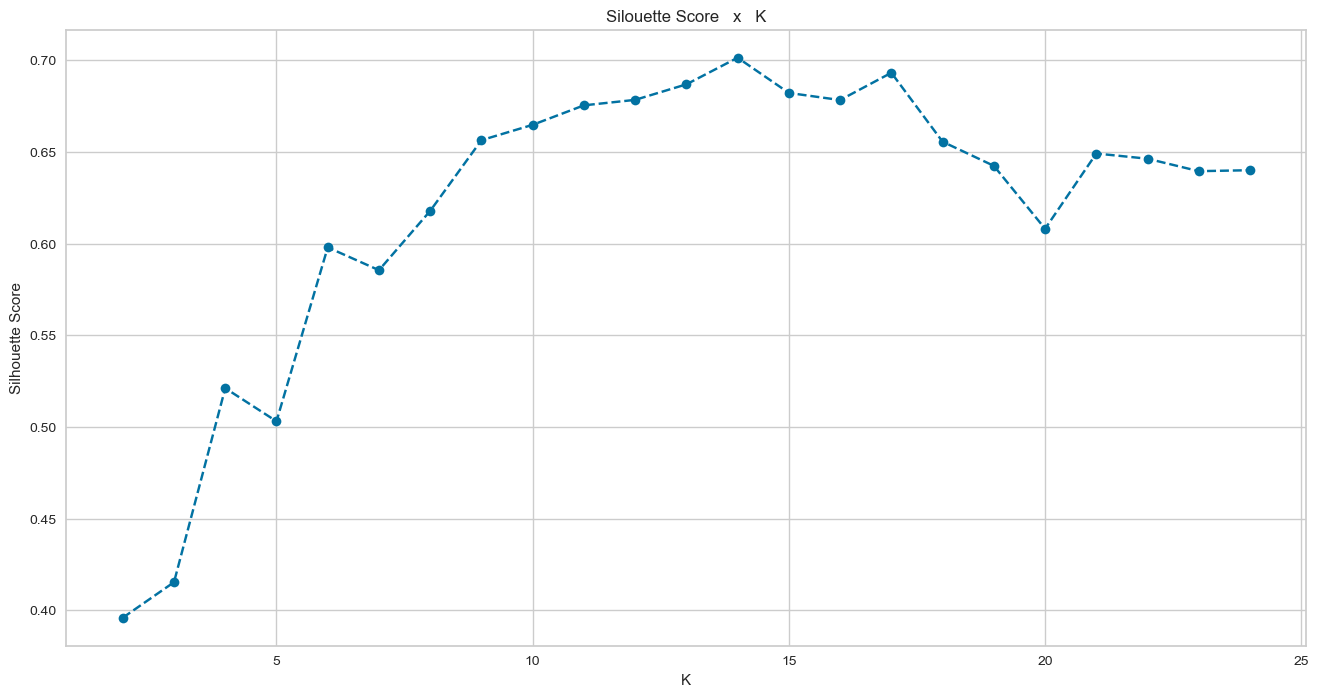

In [52]:
plt.figure(figsize=[16,8])
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K');

## 7.3 - Hierarchial Clustering

In [53]:
# model definition and training
#hc_model = hc.linkage(X, 'ward')

In [54]:
#hc.dendrogram(
#    hc_model,
#    leaf_rotation=90,
#    leaf_font_size=8
#)
#
#plt.plot()

In [55]:
#hc.dendrogram(
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True
#)
#
#plt.plot()

### 7.3.1 - HClustering Silhouette Score

In [56]:
hc_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, 'ward')
    
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')
    
    # metrics
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

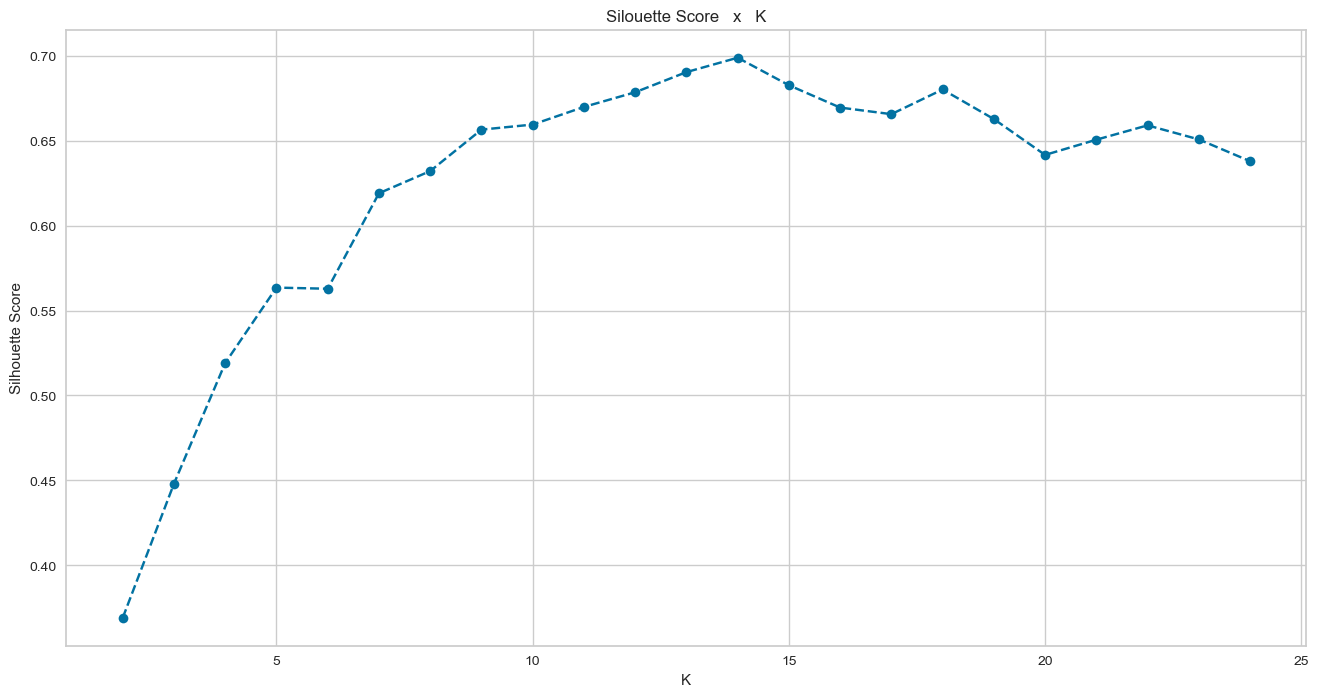

In [57]:
plt.figure(figsize=[16,8])
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silouette Score   x   K');

## 7.4 - DBSCAN

In [58]:
eps=2.50
min_samples=20

# model definition
dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training and predict
labels = dbscan_model.fit_predict(X)

# metric
sil = m.silhouette_score(X, labels, metric='euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number of clusters: {}'.format(len(np.unique(labels))))
print(np.unique(labels))

Silhouette Score: 0.6796370148658752
Number of clusters: 14
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [59]:
#dbscan_list = [0.00, 0.48611, 0.00, 0.00, 0.00, 0.00]

## 7.5 - Results

In [60]:
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
     'GMM':       gmm_list,
     'HC':         hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.404283,0.457538,0.521927,0.556727,0.597989,0.619014,0.632062,0.656453,0.659435,0.669807,0.678448,0.686919,0.698771,0.682591,0.669353,0.665468,0.651987,0.639884,0.632665,0.647898,0.657282,0.628913,0.637165
GMM,0.395964,0.415339,0.521167,0.503114,0.597989,0.585543,0.617894,0.656453,0.664836,0.675459,0.678448,0.686919,0.701436,0.682226,0.678350,0.693232,0.655616,0.642458,0.608142,0.649180,0.646348,0.639551,0.640078
HC,0.369202,0.448127,0.519133,0.563482,0.562810,0.619014,0.632062,0.656453,0.659435,0.669807,0.678448,0.690299,0.698771,0.682591,0.669433,0.665557,0.680074,0.662677,0.641563,0.650524,0.658963,0.650692,0.637884


## 7.7 - Silhouette Analysis

In [61]:
#fig, ax = plt.subplots(3, 2)
#fig.set_size_inches(25, 20)
#
#for k in clusters:
#    q, mod = divmod(k, 2)
#    ax[q-1, mod].set_xlim([-0.1, 1])
#    ax[q-1, mod].set_ylim([0, len(X) + (k+1)*10])
#    
#    # model definition and training
#    hc_model = hc.linkage(X, 'ward')
#    
#    # model predict
#    labels = hc.fcluster(hc_model, k, criterion='maxclust')
#    
#    # performance
#    ss = m.silhouette_score(X, labels, metric='euclidean')
#    print('For k = {}  |  Silhouette Score: {}'.format(k, ss))
#    samples_silhouette_values = m.silhouette_samples(X, labels)
#    
#    y_lower = 10
#    for i in range(k):     
#        # select clusters
#        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
#        
#        # sort values
#        ith_samples_silhouette_values.sort()
#        
#        # size clusters
#        size_cluster_i = ith_samples_silhouette_values.shape[0]
#        y_upper = y_lower + size_cluster_i
#        
#        cmap = plt.get_cmap('Spectral')
#        color = cmap(i/k)
#                
#        ax[q-1, mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
#        
#        y_lower = y_upper + 10
#    ax[q-1, mod].set_yticks([])
#    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8 - TREINO DOS MODELOS

In [62]:
# Number of clusters
k = 8

## 8.1 - K-Means

In [63]:
# KMeans
# mode definition
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels_kmeans = kmeans.labels_

In [64]:
# WSS
print('WSS value: {}'.format(kmeans.inertia_))

# Silhouette Score
print('SS value: {}'.format(m.silhouette_score(X, labels_kmeans, metric='euclidean')))

WSS value: 23080.5078125
SS value: 0.6367669105529785


## 8.2 - GMM

In [93]:
# GMM
# model definition
gmm = mx.GaussianMixture(n_components=k, n_init=300, random_state=32)

# model training
gmm.fit(X)

# model predict
labels_gmm = gmm.predict(X)

In [94]:
# Silhouette Score
print('SS value: {}'.format(m.silhouette_score(X, labels_gmm, metric='euclidean')))

SS value: 0.6240370869636536


## 8.3 - HC

In [67]:
# HC
# model definition and training
hcm = hc.linkage(X, 'ward')

# model predict
labels_hc = hc.fcluster(hcm, k, criterion='maxclust')

In [68]:
# Silhouette Score
print('SS value: {}'.format(m.silhouette_score(X, labels_hc, metric='euclidean')))

SS value: 0.6320618391036987


# 9 - ANÁLISE DOS CLUSTERS

## 9.1 - Creating DataFrames

### 9.1.1 - KMeans

In [69]:
df9_kmeans = X.copy()
df9_kmeans['cluster'] = labels_kmeans
df9_kmeans.head()

,embedding_x,embedding_y,cluster
0,10.603584,18.021975,4
1,15.192944,11.075175,3
2,11.436817,18.614090,4
3,-1.617732,2.295417,7
4,-5.436786,8.880532,7


### 9.1.2 - GMM

In [70]:
df9_gmm = X.copy()
df9_gmm['cluster'] = labels_gmm
df9_gmm.head()

,embedding_x,embedding_y,cluster
0,10.603584,18.021975,3
1,15.192944,11.075175,7
2,11.436817,18.614090,3
3,-1.617732,2.295417,1
4,-5.436786,8.880532,0


### 9.1.3 - HC

In [71]:
df9_hc = X.copy()
df9_hc['cluster'] = labels_hc
df9_hc.head()

,embedding_x,embedding_y,cluster
0,10.603584,18.021975,5
1,15.192944,11.075175,6
2,11.436817,18.614090,5
3,-1.617732,2.295417,4
4,-5.436786,8.880532,4


## 9.2 - Visualization Inspection

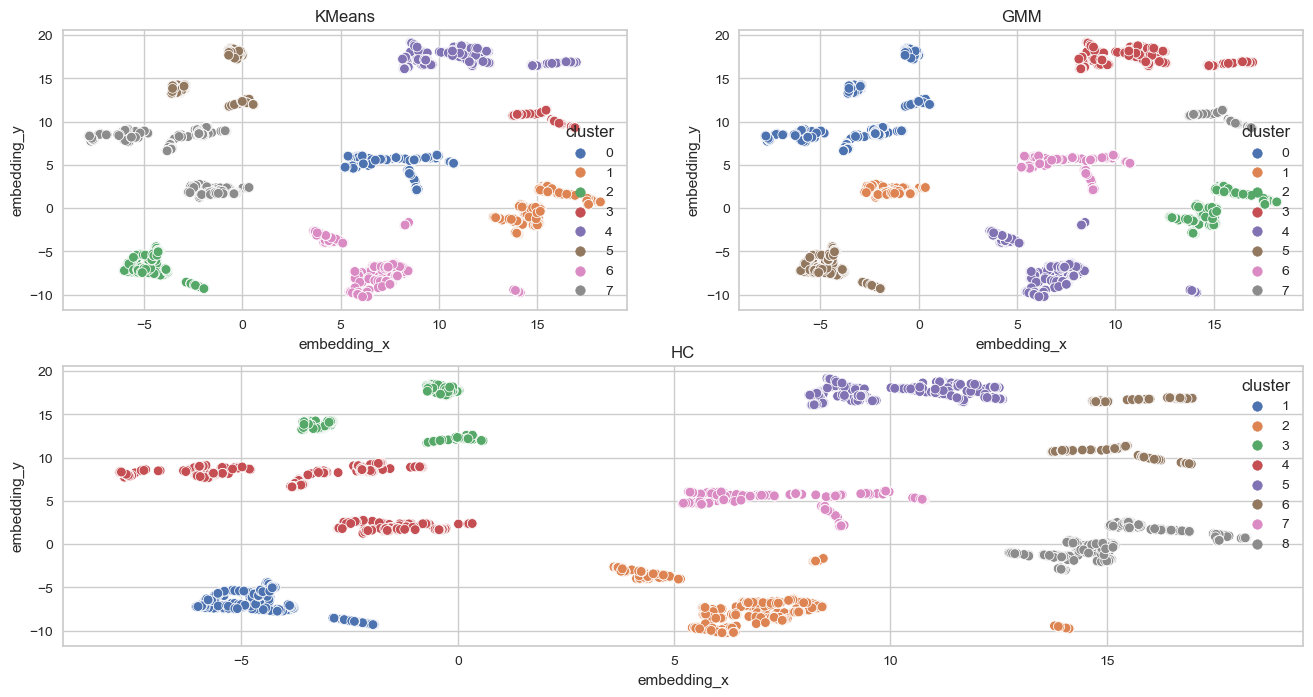

In [72]:
plt.figure(figsize=[16, 8])
grid = GridSpec(2,2)

# Kmeans
plt.subplot(grid[0, 0])
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9_kmeans, palette='deep')
plt.title('KMeans')

# GM
plt.subplot(grid[0, 1])
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9_gmm, palette='deep')
plt.title('GMM')

# HC
plt.subplot(grid[1, :])
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9_hc, palette='deep')
plt.title('HC');

## 9.3 - Cluster Profile

In [73]:
cols_selected

['customer_id',
 'gross_revenue',
 'recency_days',
 'qtde_products',
 'frequency',
 'qtde_returns']

In [74]:
df92 = df4[cols_selected].copy()
df92['cluster'] = labels_gmm     # Escolha do GMM
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,3
1,13047,3232.59,56.0,171.0,0.028302,35.0,7
2,12583,6705.38,2.0,232.0,0.040323,50.0,3
3,13748,948.25,95.0,28.0,0.017921,0.0,1
4,15100,876.00,333.0,3.0,0.073171,22.0,0


In [75]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = np.round(100*df_cluster['customer_id']/df_cluster['customer_id'].sum(), 2).astype(str)+'%'

# Avg gross_revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
#df_avg_gross_revenue['gross_revenue'] = '$' + np.round(df_avg_gross_revenue['gross_revenue'], 2).astype(str)
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency_days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
#df_avg_recency_days['recency_days'] = np.round(df_avg_recency_days['recency_days'], 2).astype(str) + ' dias'
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_avg_invoice_no = df92[['qtde_products', 'cluster']].groupby('cluster').mean().reset_index()
#df_avg_invoice_no['qtde_products'] = np.round(df_avg_invoice_no['qtde_products'], 2).astype(str) + ' produtos'
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_frequency['frequency'] = np.round(df_frequency['frequency'], 2).astype(str)
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')

# Returns
df_returns = df92[['qtde_returns', 'cluster']].groupby('cluster').mean().reset_index()
#df_returns['qtde_returns'] = np.round(df_returns['qtde_returns'], 2).astype(str) + ' retornos'
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')

df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
3,3,468,15.77%,8836.136389,21.438034,424.134615,0.09,149.271368
7,7,145,4.89%,3164.253379,34.427586,173.875862,0.06,23.482759
6,6,330,11.12%,2515.687182,44.433333,128.430303,0.04,21.466667
4,4,532,17.92%,2071.837105,57.614662,69.725564,0.05,16.069549
2,2,404,13.61%,1689.182401,54.801980,89.202970,0.05,11.542079
5,5,322,10.85%,971.025435,75.329193,37.462733,0.07,6.571429
1,1,175,5.9%,827.478286,92.022857,26.822857,0.16,22.868571
0,0,592,19.95%,553.770946,114.917230,14.167230,0.29,6.538851


**Nomeação dos clusters**

**3**   ->   Cluster Insiders

**7**   ->   Cluster More Products

**6**   ->   Cluster Spend Money

**2**   ->   Cluster Even More Products

**4**   ->   Cluster Less Days

**5**   ->   Cluster Less 1K Gross Revenue

**1**   ->   Cluster Stop Returners

**0**   ->   Cluster More Buy

# 10 - ANÁLISE EXPLORATÓRIO DE DADOS PÓS MODELAGEM

In [76]:
df10 = df92.copy()

## 10.1 - MindMap de hipóteses

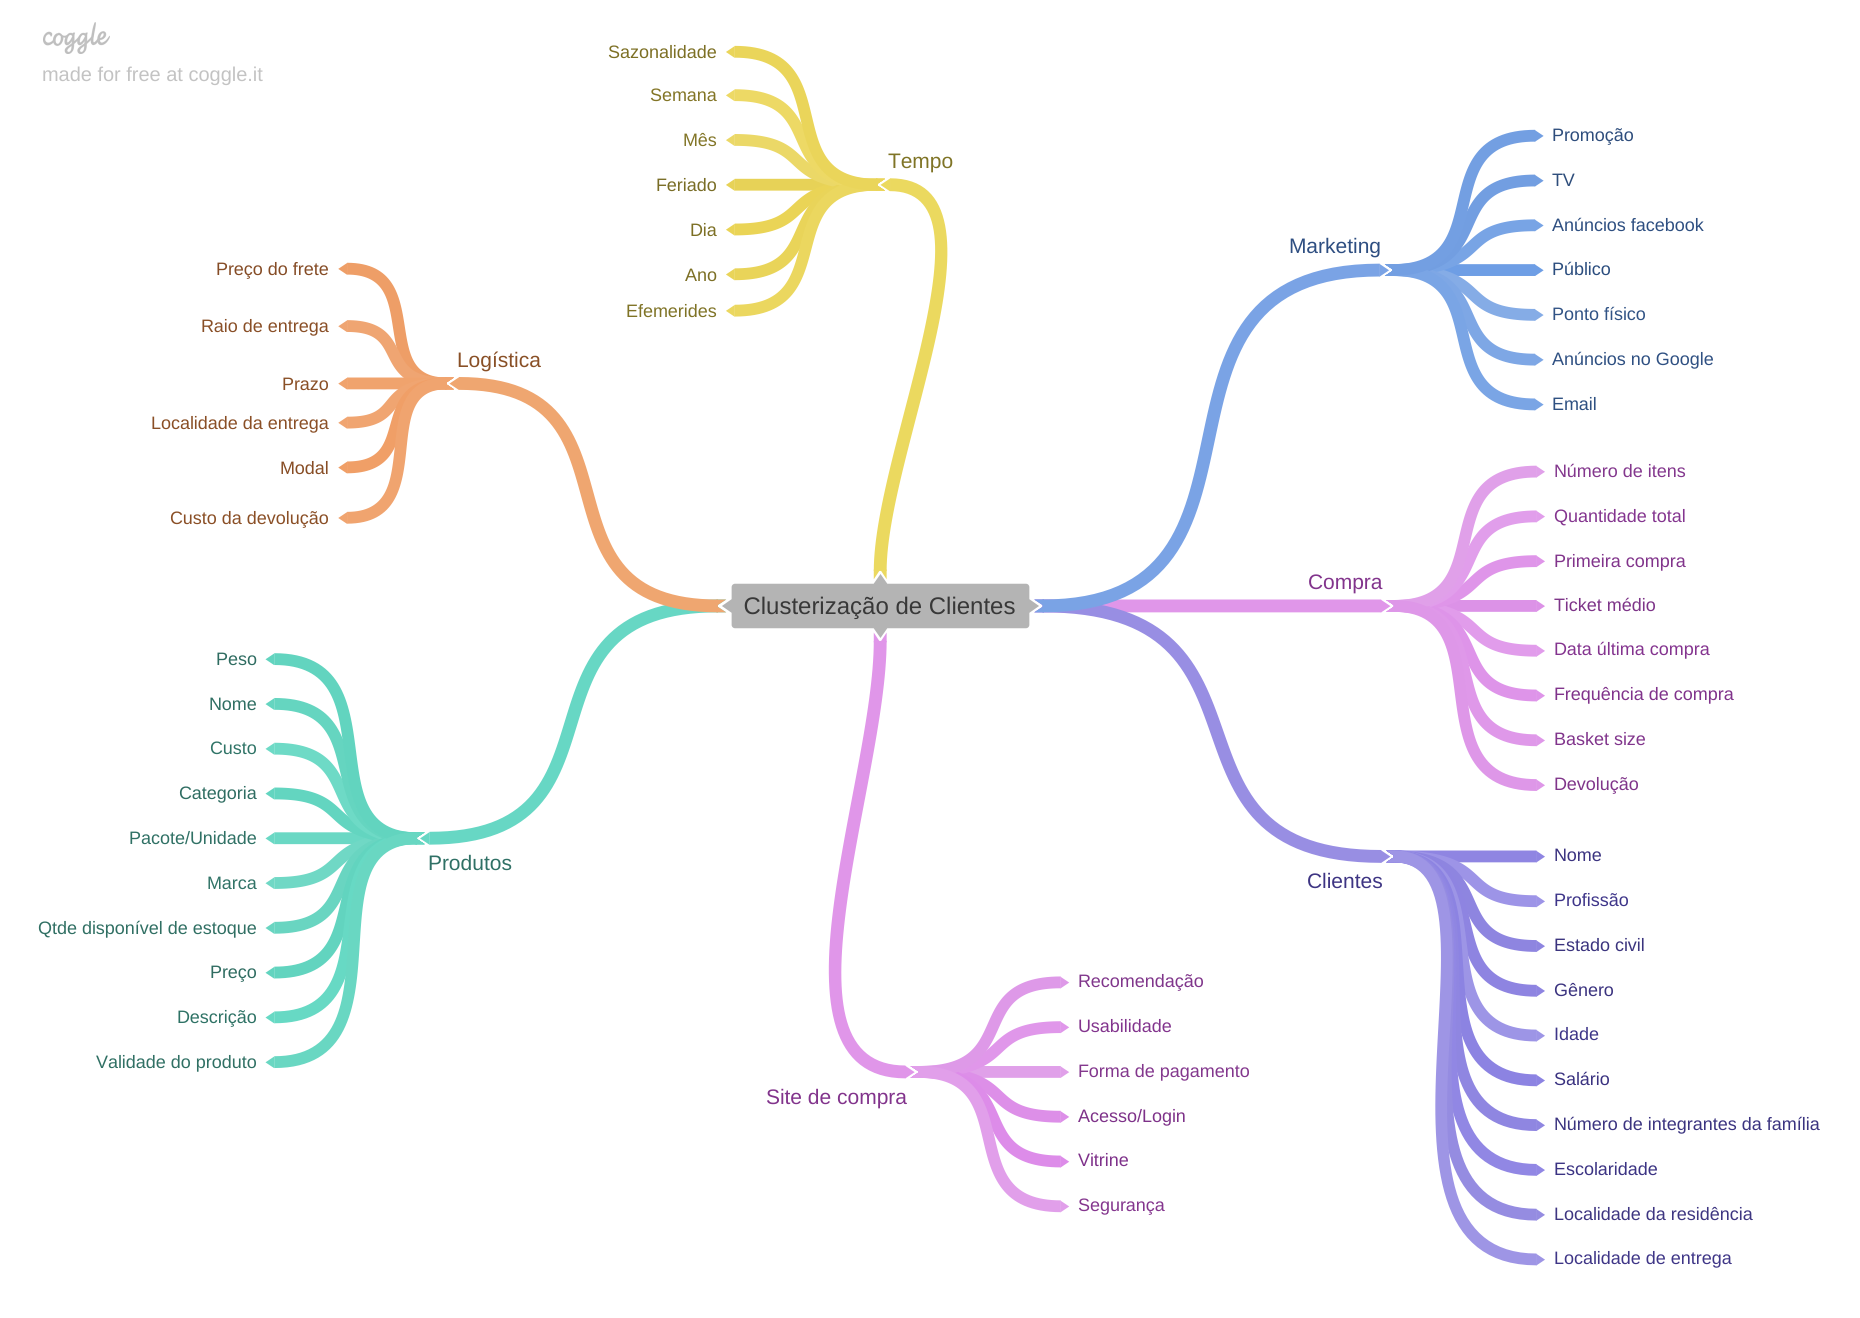

In [77]:
Image('images/mind_map.png')

## 10.2 - Hipóteses

### 10.2.1 - Hipóteses de Compra

1. Os clientes do cluster Insiders usam cartão de crédito em 80% das compras.
2. Os clientes do cluster Insiders possuem um ticket médio de 10% acima do cluster More Products
3. Os clientes do cluster Insiders possuem basket size acima de 5 produtos em média
4. **(SELECIONADA)** O cluster Insiders possui um volume unidades de produto comprado acima de 10% do total de compras
5. **(SELECIONADA)** O cluster Insiders possui um volume de faturamento de compras acima de 10% do total de compras
6. **(SELECIONADA)** O cluster Insiders tem um número médio de devoluções abaixo da média da base total de clientes
7. **(SELECIONADA)** A mediana do faturamento do cluster Insiders é 10% maior que a mediana do faturamento geral
8. **(SELECIONADA)** A maior parte dos clientes do cluster Insiders está concentrada no 3º quartil

#### H1: O cluster Insiders possui um volume unidades de produto comprado acima de 10% do total de compras
**Verdadeiro:** O cluster Insiders possui um volume de unidades de produto comprado de 54%.

In [78]:
# Soma da qtde de produtos do cluster Insiders
df_sales_insiders = df10.loc[df10['cluster']==3, 'qtde_products'].sum()
df_sales_total = df10.loc[:, 'qtde_products'].sum()

# Razão
print('% Compra Insiders: {:.2f}%'.format(100*df_sales_insiders/df_sales_total))

% Compra Insiders: 54.48%


#### H2: O cluster Insiders possui um volume de faturamento de compras acima de 10% do total de compras
**Verdadeiro:** O cluster Insiders possui um volume de faturamento de compras de 52%.

In [79]:
# soma da qtde de produtos do Insiders | GMV - Gross Margin Value
df_gmv_insiders = df10.loc[df10['cluster']==3, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()

# Representatividade
print('% GMV Insiders: {:.2f}%'.format(100*df_gmv_insiders/df_gmv_total))

% GMV Insiders: 51.73%


#### H3: O cluster Insiders tem um número médio de devoluções abaixo da média da base total de clientes
**Falso:** O cluster Insiders possui um número médio de devoluções maior que o total.

In [80]:
# Média de devolução do cluster Insiders
df_avg_returns_insiders = df10.loc[df10['cluster']==3, 'qtde_returns'].mean()
df_avg_returns_total = df10.loc[:, 'qtde_returns'].mean()

# Representatividade
print('% Avg Returns Insiders: {:.2f}% | Avg Return Insiders: {}  vs  Avg Return All: {}'.format(100*df_avg_returns_insiders/df_avg_returns_total, np.round(df_avg_returns_insiders,0), np.round(df_avg_returns_total,0)))

% Avg Returns Insiders: 427.85% | Avg Return Insiders: 149.0  vs  Avg Return All: 35.0


#### H4: A mediana do faturamento do cluster Insiders é 10% maior que a mediana do faturamento geral
**Verdadeiro:** A mediana do faturamento do cluster Insiders é 277% maior que o geral.

In [81]:
# soma da qtde de produtos do Insiders | GMV - Gross Margin Value
df_median_gmv_insiders = df10.loc[df10['cluster']==3, 'gross_revenue'].median()
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()

# Representatividade
print('% Aumento GMV Insiders: {:.2f}%'.format(100*(df_median_gmv_insiders - df_median_gmv_total)/df_median_gmv_total))

% Aumento GMV Insiders: 276.48%


#### H5: A maior parte dos clientes do cluster Insiders está concentrada no 3º quartil
**Falso:** Estão concentrados nos 1º e 2º quartis.

<AxesSubplot:xlabel='gross_revenue'>

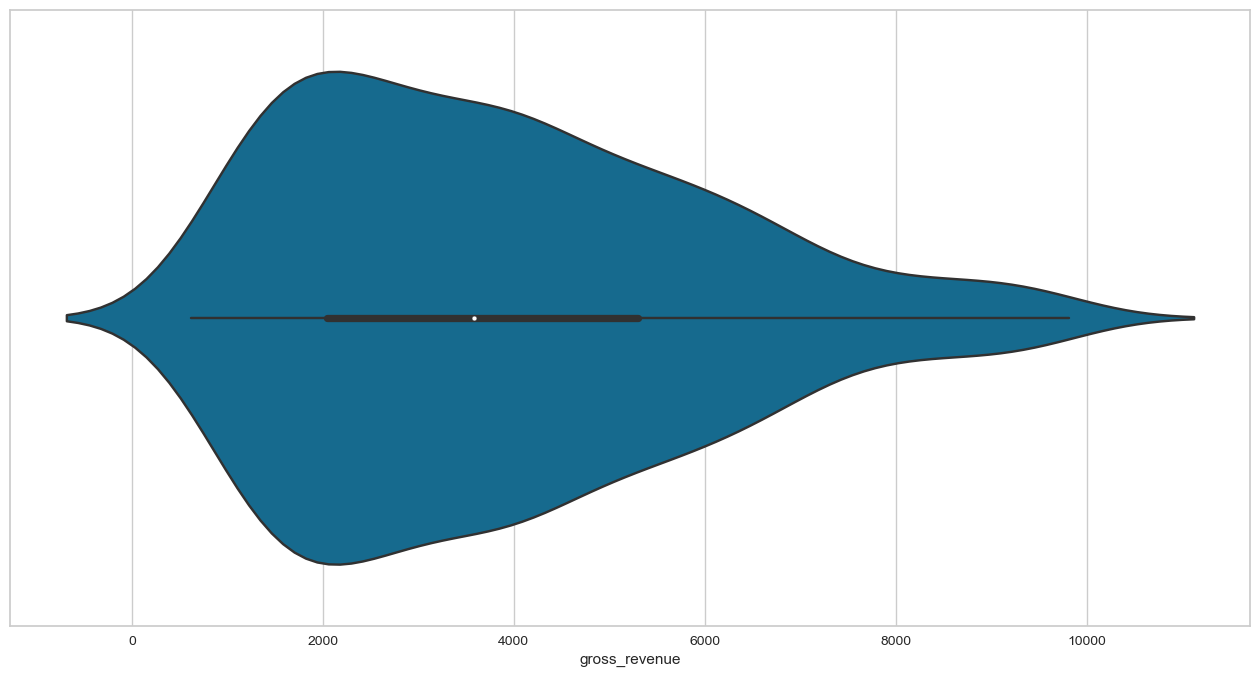

In [82]:
plt.figure(figsize=[16, 8])
sns.violinplot(x='gross_revenue', data=df10[(df10['cluster']==3) & (df10['gross_revenue']<=10000)])

### 10.2.2 - Hipóteses de Cliente

1. 60% dos clientes do cluster Insiders possuem o estado civil como solteiro
2. 10% dos clientes do cluster Insiders estão na faixa de 24 a 35 anos
3. 40% das localidades de entrega do cluster Insiders estão dentro de um raio de 50km
4. 5% dos clientes do cluster Insiders recebem mais de $100000.00 anualmente
5. 90% dos clientes do cluster Insiders têm ensino superior completo

### 10.2.3 - Hipóteses de Produto

1. 30% de todos os produtos em apcotes grandes são comprados pelos clientes do cluster Insiders
2. A mediana dos preços dos produtos comprados pelos clientes do cluster Insiders é 10% maior do que a mediana de todos os preços dos produtos
3. O percentil do preço dos produtos comprados pelos clientes do cluster Insiders
2. O peso médio dos produtos comprados pelos clientes do cluster Insiders é maior do que o peso médio dos outros clusters
3. A idade média dos produtos comprados pelos clientes do cluster Insiders é menor do que 15 dias

## 10.3 - Perguntas do negócio

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
2. Quantos clientes farão parte do grupo?
3. Quais as principais características desses clientes ?
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
7. Quais as condições para uma pessoa ser removida do Insiders ?
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

### 1. Quem são as pessoas elegíveis para participar do programa de Insiders ?

In [83]:
df10[df10['cluster']==3]['customer_id'].head()

0     17850
2     12583
6     14688
8     15311
12    16029
Name: customer_id, dtype: int32

### 2. Quantos clientes farão parte do grupo?

In [84]:
df10[df10['cluster']==3]['customer_id'].size

468

### 3. Quais as principais características desses clientes ?

In [85]:
print('CANDIDATOS AO GRUPO INSIDERS:')
print('   - Número de customers: {} ({}% dos customers)'.format(df10[df10['cluster']==3]['customer_id'].size, np.round(100*df10[df10['cluster']==3]['customer_id'].size/df10['customer_id'].size,2)))
print('   - Faturamento médio: R$ {}'.format(np.round(df10[df10['cluster']==3]['gross_revenue'].mean(), 2)))
print('   - Faturamento somado: R$ {} ({}% do total)'.format(df10[df10['cluster']==3]['gross_revenue'].sum(), np.round(100*df10[df10['cluster']==3]['gross_revenue'].sum()/df10['gross_revenue'].sum(),2)))
print('   - Recência média: {} dias'.format(np.round(df10[df10['cluster']==3]['recency_days'].mean(), 2)))
print('   - Média da qtde de produtos comprados: {} prod/customer'.format(np.round(df10[df10['cluster']==3]['qtde_products'].mean(), 2)))
print('   - Frequência média de compra: {} produtos/dia'.format(np.round(df10[df10['cluster']==3]['frequency'].mean(), 2)))

CANDIDATOS AO GRUPO INSIDERS:
   - Número de customers: 468 (15.77% dos customers)
   - Faturamento médio: R$ 8836.14
   - Faturamento somado: R$ 4135311.83 (51.73% do total)
   - Recência média: 21.44 dias
   - Média da qtde de produtos comprados: 424.13 prod/customer
   - Frequência média de compra: 0.09 produtos/dia


### 4. Qual a porcentagem de contribuição do faturamento vindo do Insiders?

In [90]:
print('% de contribuição: {}%'.format(np.round(100*df10.loc[df10['cluster']==3, 'gross_revenue'].sum()/df10.loc[:, 'gross_revenue'].sum(), 2)))

% de contribuição: 51.73%


### 5. Qual a expectativa de faturamento desse grupo para os próximos meses?

### 6. Quais as condições para uma pessoa ser elegível ao Insiders?

### 7. Quais as condições para uma pessoa ser removida do Insiders?